In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nimabeig
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 1.19GB/s]

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam #adam optimizer
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary # to print out how the model architechture will be at the end
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt #we want this to plot the accuracy plot
import pandas as pd
import numpy as np

#pytorch does not automatically detect gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()


,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [4]:
data_df.dropna(inplace = True)   #drop any rows that has NAN
data_df.drop('id',axis = 1,inplace= True ) # drop the id column cuz it does not help us with calculation
print(data_df.shape)

(18185, 11)


In [5]:
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()


data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [6]:
import numpy as np
X = np.array(data_df.iloc[:, :-1]) #it will take all the rows and all the colulmns except the last one
Y = np.array(data_df.iloc[:, -1]) #just took the last column


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [8]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [10]:
class dataset(Dataset):
  def __init__(self, X, Y): #our constructor
    self.X = torch.tensor(X, dtype = torch.float32).to(device) #we change whatever our data(input) is to tensor
    self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)    #The shape of our input

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]    #get an specific item outta table

In [11]:
training_data = dataset(X_train, y_train)
validate_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)     #we made objects of our class dataset

In [12]:
train_dataloader = DataLoader(training_data , batch_size = 32 ,shuffle = True)
validate_dataloader = DataLoader(validate_data , batch_size= 32, shuffle=True)
testing_dataloader = DataLoader(testing_data , batch_size= 32 , shuffle=True)

In [13]:
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()       # we are using the exact constructor of nn.module by using the super keyboard

    self.input_layer = nn.Linear(10, HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)   # only one out put which classifies 0.5 >  == 0 or 0.5 < 0
    self.activation = nn.Sigmoid()

  def forward(self, x): #how data goes into model
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.activation(x)
    return x

model = MyModel().to(device)

In [14]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [15]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

In [16]:
total_loss_train_plot = [] #so in this code, you go thoroght the dataset 10 times and train the model to learn loss and acc
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []
epochs = 10
for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for data in train_dataloader:
    inputs, lables = data

    prediction = model(inputs).squeeze(1)

    batch_loss = criterion(prediction, lables) # The model predicts outputs for a batch (say, 8 rice samples).

    total_loss_train += batch_loss.item()

    acc = (prediction.round() == lables).sum().item()
    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for data in validate_dataloader:
      inputs, lables = data
      prediction = model(inputs).squeeze(1)
      total_loss_val += criterion(prediction, lables).item()
      acc = (prediction.round() == lables).sum().item()
      total_acc_val += acc
  total_loss_train_plot.append(round(total_loss_train/1000 , 4)) #normalizing the data
  total_loss_val_plot.append(round(total_loss_val/1000 , 4))

  total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4 ))  #making a percentage for it.
  total_acc_val_plot.append(round(total_acc_val/validate_data.__len__() * 100 , 4))

  print(f''' Epoch no. {epoch + 1} Train Loss: {round(total_loss_train / 1000 , 4)} Train Accuracy: {round(total_acc_train / training_data.__len__() * 100, 4)}
  Validation Loss: {round(total_loss_val/1000 , 4)} Validation Accuracy{round(total_acc_val/validate_data.__len__() * 100 , 4)}''')

  print('=' * 25)


 Epoch no. 1 Train Loss: 0.2457 Train Accuracy: 78.4272
  Validation Loss: 0.0428 Validation Accuracy97.654
 Epoch no. 2 Train Loss: 0.1386 Train Accuracy: 97.761
  Validation Loss: 0.0197 Validation Accuracy98.3138
 Epoch no. 3 Train Loss: 0.0661 Train Accuracy: 98.2324
  Validation Loss: 0.0108 Validation Accuracy98.2771
 Epoch no. 4 Train Loss: 0.0405 Train Accuracy: 98.4131
  Validation Loss: 0.0076 Validation Accuracy98.4604
 Epoch no. 5 Train Loss: 0.0301 Train Accuracy: 98.4916
  Validation Loss: 0.0062 Validation Accuracy98.607
 Epoch no. 6 Train Loss: 0.0251 Train Accuracy: 98.5388
  Validation Loss: 0.0053 Validation Accuracy98.4604
 Epoch no. 7 Train Loss: 0.0221 Train Accuracy: 98.5859
  Validation Loss: 0.0049 Validation Accuracy98.5704
 Epoch no. 8 Train Loss: 0.0204 Train Accuracy: 98.5859
  Validation Loss: 0.0046 Validation Accuracy98.6437
 Epoch no. 9 Train Loss: 0.0191 Train Accuracy: 98.6016
  Validation Loss: 0.0044 Validation Accuracy98.4971
 Epoch no. 10 Train Lo

In [17]:
#testing
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for data in testing_dataloader:
    inputs, lables = data
    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion(prediction, lables).item()
    total_loss_test += batch_loss_test

    acc_test = (prediction.round() == lables).sum().item()
    total_acc_test += acc_test
  print("Accuracy: " , round(total_acc_test / testing_data.__len__() * 100, 4))


Accuracy:  98.7537


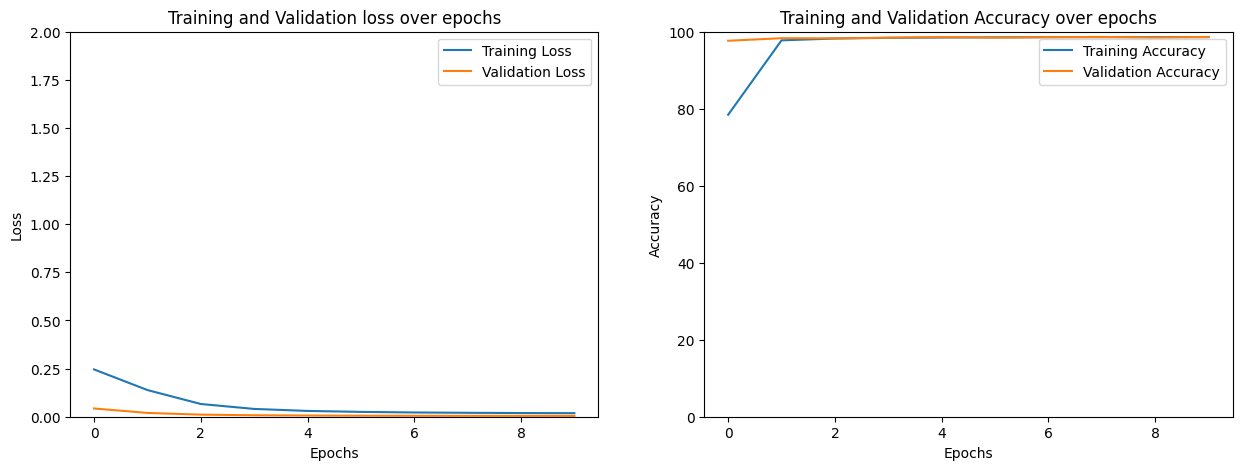

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[15,5])

axs[0].plot(total_loss_train_plot, label = 'Training Loss')
axs[0].plot(total_loss_val_plot, label = 'Validation Loss')
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(0,2)
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = 'Training Accuracy')
axs[1].plot(total_acc_val_plot, label = 'Validation Accuracy')
axs[1].set_title("Training and Validation Accuracy over epochs")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [22]:
area = 2353 / original_df['Area'].abs().max()
MajorAxisLength = 81 / original_df['MajorAxisLength'].abs().max()
MinorAxisLength = 42 / original_df['MinorAxisLength'].abs().max()
Eccentricity = 32 / original_df['Eccentricity'].abs().max()
ConvexArea = 12 / original_df['ConvexArea'].abs().max()
EquivDiameter = 33 / original_df['EquivDiameter'].abs().max()
Extent = 98 / original_df['Extent'].abs().max()
Perimeter = 927 / original_df['Perimeter'].abs().max()
Roundness = 677 / original_df['Roundness'].abs().max()
AspectRation = 24 / original_df['AspectRation'].abs().max()

device = next(model.parameters()).device   # 'cuda:0' or 'cpu'

x = torch.tensor(
    [area, MajorAxisLength, MinorAxisLength, Eccentricity,
     ConvexArea, EquivDiameter, Extent, Perimeter,
     Roundness, AspectRation],
    dtype=torch.float32,
    device=device      # put input on same device as model
).unsqueeze(0)         # add batch dimension if needed

model.eval()
with torch.no_grad():
    my_prediction = model(x)


In [25]:
print(my_prediction.item())


0.0
